In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates as mdates

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                                AutoMinorLocator)

import warnings
import arviz as az
import numpy as np
import pymc3 as pm
import theano.tensor as tt                                       
from scipy.integrate import solve_ivp
from scipy.stats import norm      
import numpy as numpy


WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


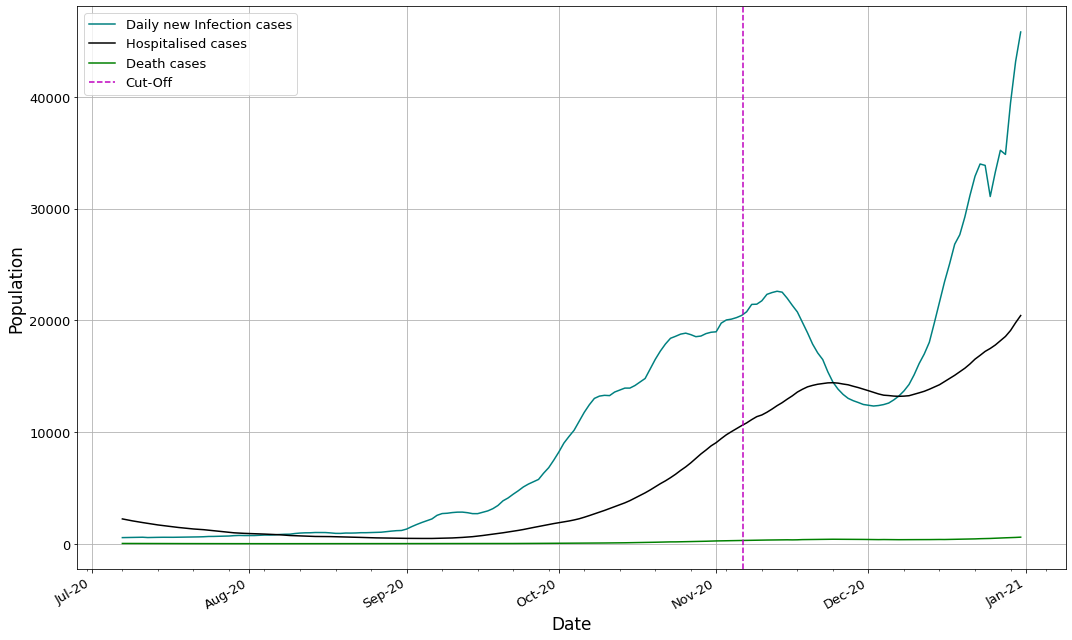

In [47]:
weeks = mdates.WeekdayLocator()
years = mdates.YearLocator()
months = mdates.MonthLocator()
weekdays = mdates.DayLocator()
dateFmt = mdates.DateFormatter('%b-%y')
dateFmt_day = mdates.DateFormatter('%d-%b')


def rolling_avg_df(dfs, N=7):
     # Define a rolling average function
     dfs = dfs.loc[:].rolling(N, win_type="boxcar").mean()
     return dfs

query = 'https://api.coronavirus.data.gov.uk/v2/data?areaType=nation&areaName={}&metric=hospitalCases&metric=newAdmissions&metric=newCasesBySpecimenDate&metric=newDeaths28DaysByDeathDate&format=csv'
area = 'England'
df = pd.read_csv(query.format(area))
df.set_index(pd.to_datetime(df['date']),inplace=True)
df.sort_index(inplace=True)

#truncate in dates if required
df = df.truncate(before=dt.datetime(2020,7,1),after=dt.datetime(2020,12,31))
# df.truncate(before=dt.datetime(2020,1,8),after=dt.datetime(2020,12,31))

fig, ax = plt.subplots(figsize=(15,9),sharex= True, facecolor='white')
ax.plot(df.index,rolling_avg_df(df['newCasesBySpecimenDate']), label = 'Daily new Infection cases', color = 'teal') # daily number of new cases
# ax.plot(df.index,rolling_avg_df(df['newAdmissions']), label = 'new admissions') # daily number of new admissions to hospital of patients with COVID-19
ax.plot(df.index,rolling_avg_df(df['hospitalCases']), label = 'Hospitalised cases', color = 'black') # daily number of confirmed COVID-19 patients in hospital
ax.plot(df.index,rolling_avg_df(df['newDeaths28DaysByDeathDate']), label = 'Death cases', color = 'g') # Daily numbers of people who died within 28 days of being identified as a COVID-19 case by a positive test. Data are shown by date of death.
ax.axvline(dates1[125:126], c = 'm',ls = '--', label = 'Cut-Off')
# save data for daily number of new cases


ax.legend()
# ax.grid(which='both')
# ax.set_xlabel('Date')
# ax.set_ylabel('Counts')
# ax.set_yscale('log')
#ax.set_title('{} Cases'.format(reg))

# format the ticks
month_dateFmt = mdates.DateFormatter('%b')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(dateFmt)
ax.xaxis.set_minor_locator(weeks)

#ax.xaxis.set_major_locator(weeks)
#ax.xaxis.set_major_formatter(dateFmt_day)
#ax.xaxis.set_minor_locator(weekdays)

# ax.tick_params(axis="both", direction="in", which="both", 
# right=True,left=True, top=True, bottom=True)




plt.xlabel("Date", fontsize = 17)
plt.ylabel("Population", fontsize = 17)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=13)

#ax.legend(ncol=1, title='')
_= fig.autofmt_xdate()
plt.grid()
plt.tight_layout()



# plt.plot(t,I_data/N,label = 'Infected Data',color='teal')
# plt.plot(t,I/N,label = 'Infected Signal',color='black')
# plt.plot(t,H_data/N,label = 'Hospitalised Data',color='green')
# plt.plot(t,H/N,label = 'Hospitalised Signal',color='m')

# plt.xlabel("Time[Days]", fontsize = 15)
# plt.ylabel("Fraction of Population", fontsize = 15)


# plt.grid()

plt.savefig('Actual Dat')
# plt.show()


In [48]:
def sirh_odes(t, x, b, g,ih,hr, N):
    "SIRH Model"
  

    S = x[0]
    I = x[1]
    H = x[2]
    R = x[3]


    dSdt = -(b/N)*S*I
    dIdt = (b/N)*S*I - g*I - ih*I
    dhdt = ih*I - hr * H
    dRdt = g*I + hr * H

   
    
    return dSdt, dIdt, dhdt, dRdt

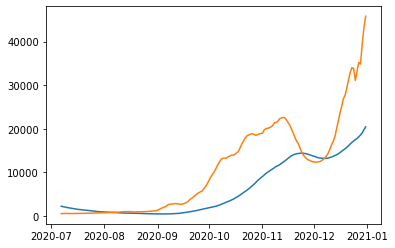

In [49]:
new_cases_I = rolling_avg_df(df['newCasesBySpecimenDate'])
# new_cases.dropna()
new_cases =  new_cases_I.to_numpy()
data = new_cases[6:]
hospital_data = rolling_avg_df(df['hospitalCases'])


plt.plot(new_cases_I.index, hospital_data)
plt.plot(new_cases_I.index, new_cases)

In [50]:
hospital_data.head()

date
2020-07-01   NaN
2020-07-02   NaN
2020-07-03   NaN
2020-07-04   NaN
2020-07-05   NaN
Name: hospitalCases, dtype: float64

In [51]:
pd.date_range(start='16/09/2020', end='31/12/2020')

DatetimeIndex(['2020-09-16', '2020-09-17', '2020-09-18', '2020-09-19',
               '2020-09-20', '2020-09-21', '2020-09-22', '2020-09-23',
               '2020-09-24', '2020-09-25',
               ...
               '2020-12-22', '2020-12-23', '2020-12-24', '2020-12-25',
               '2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', length=107, freq='D')

In [52]:
new_cases_I = rolling_avg_df(df['newCasesBySpecimenDate'])
print(new_cases_I)
hospital_data = rolling_avg_df(df['hospitalCases'])
print(hospital_data)

date
2020-07-01             NaN
2020-07-02             NaN
2020-07-03             NaN
2020-07-04             NaN
2020-07-05             NaN
                  ...     
2020-12-27    35213.142857
2020-12-28    34841.428571
2020-12-29    39457.857143
2020-12-30    43152.142857
2020-12-31    45800.142857
Name: newCasesBySpecimenDate, Length: 184, dtype: float64
date
2020-07-01             NaN
2020-07-02             NaN
2020-07-03             NaN
2020-07-04             NaN
2020-07-05             NaN
                  ...     
2020-12-27    18165.857143
2020-12-28    18554.000000
2020-12-29    19086.000000
2020-12-30    19783.000000
2020-12-31    20426.000000
Name: hospitalCases, Length: 184, dtype: float64


In [53]:
new_cases_I = new_cases_I.dropna()
print(new_cases_I)
hospital_data = hospital_data.dropna()
print(hospital_data)

date
2020-07-07      551.571429
2020-07-08      562.285714
2020-07-09      580.428571
2020-07-10      578.714286
2020-07-11      585.571429
                  ...     
2020-12-27    35213.142857
2020-12-28    34841.428571
2020-12-29    39457.857143
2020-12-30    43152.142857
2020-12-31    45800.142857
Name: newCasesBySpecimenDate, Length: 178, dtype: float64
date
2020-07-07     2224.857143
2020-07-08     2136.142857
2020-07-09     2049.142857
2020-07-10     1970.857143
2020-07-11     1897.714286
                  ...     
2020-12-27    18165.857143
2020-12-28    18554.000000
2020-12-29    19086.000000
2020-12-30    19783.000000
2020-12-31    20426.000000
Name: hospitalCases, Length: 178, dtype: float64


In [54]:
#Convert to numpy
new_cases_I = new_cases_I.to_numpy()
hospital_data = hospital_data.to_numpy()


In [55]:

"Set up of Model parameters"
lc = len(new_cases_I)
t_span = np.array([1, lc])  # Time limits
t = np.linspace(t_span[0], t_span[1], t_span[1] ) # Time series, but want to only sample for period 1: 115

x_0 = np.array([54000000 - new_cases_I[0] - hospital_data[0] ,new_cases_I[0],hospital_data[0], 0])  # Initial conditions for model variables: S, I,H, R respectively
print(x_0)
N = np.sum(x_0)
print(N)
# gen = 10000

[5.39972236e+07 5.51571429e+02 2.22485714e+03 0.00000000e+00]
54000000.0


35.6


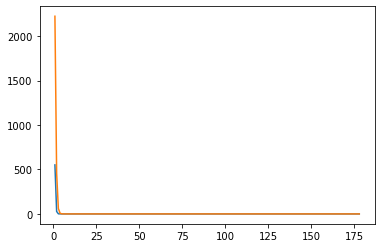

In [56]:
print(lc/5)

theta = [6, 4,5,2.2, N]
sol = solve_ivp(sirh_odes, t_span , x_0, args = theta , t_eval = t)
I = sol.y[1]
H = sol.y[2]
plt.plot(t, I)
plt.plot(t, H)
plt.show()


In [57]:
## LogLikelihood and gradient of the LogLikelihood functions

def log_likelihood(solve_ivp, sirh_odes, t_span, x_0, theta , t,  data_I, data_H):


    sol = solve_ivp(sirh_odes, t_span , x_0, args = theta , t_eval = t)
    
    S = sol.y[0]
    I = sol.y[1]
    H = sol.y[2]
    
    I = (np.multiply(S,I)*theta[0]) / theta[4]
    
    
    
        
    logp = -(0.5*np.sum(np.square((data_I[t_span[0]:t_span[1] + 1] - I)))/(np.std(data_I[t_span[0]:t_span[1]])**2)  + 0.5*np.sum(np.square((data_H[t_span[0]:t_span[1] + 1] - H)))/(np.std(data_H[t_span[0]:t_span[1]])**2)    )
    return logp


## Wrapper classes to theano-ize LogLklhood and gradient...
class Loglike(tt.Op):
    itypes = [tt.dvector]
    otypes = [tt.dscalar]

    def __init__(self, solve_ivp, sirh_odes, t_span,x_0, t, data_I, data_H):
        self.data_I = data_I
        self.data_H = data_H
        self.solve_ivp = solve_ivp
        self.sirh_odes = sirh_odes
        self.t_span = t_span
        self.x_0 = x_0
        self.t = t
    

    def perform(self, node, inputs, outputs):
        (theta,) = inputs 
        logp = log_likelihood(self.solve_ivp,self.sirh_odes, self.t_span, self.x_0, theta , self.t, self.data_I, self.data_H)
        
        outputs[0][0] = np.array(logp)


t_span_stamps = [(np.array([1, 65])),(np.array([65, 90])), (np.array([90, 125]))]
t_stamps = [(np.linspace(1, 65, 65 )),(np.linspace(65, 90, 26 )), (np.linspace(90, 125, 36 ))]
b_0_stores = []
g_0_stores = []
i_h_stores = []
hr_stores = []

for i in range(len(t_span_stamps)):
   
    if i == 0:
        x_0 = np.array([54000000 - new_cases_I[0] - hospital_data[0] ,new_cases_I[0],hospital_data[0], 0])
        N = np.sum(x_0)
    else:
        b_0 = trace["b_0"]
        g_0 = trace["g_0"]
        i_h = trace["i_h"]
        hr = trace["hr"]
        
        
        t_span = t_span_stamps[(i-1)]  # Time limits
        t = t_stamps[(i-1)] # Time series, but want to only sample for period 1: 115
        N = np.sum(x_0)
        theta = [b_0[-1], g_0[-1], i_h[-1], hr[-1], N]
        sol = solve_ivp(sirh_odes, t_span , x_0, args = theta , t_eval = t)
        
        S = sol.y[0]
        I = sol.y[1]
        H = sol.y[1]
        R = sol.y[3]
        x_0 = np.array([S[-1], I[-1],H[-1], R[-1]])
        
    
    chi_store = []
    loglike = Loglike(solve_ivp, sirh_odes, t_span_stamps[i],x_0, t_stamps[i], new_cases_I,hospital_data )
    with pm.Model() as model:
        

        # b_0 = pm.Normal('b_0', mu = 5, sigma= 10)
        b_0 = pm.Uniform('b_0',lower = 0, upper = 5)
        g_0 = pm.Uniform('g_0', lower = 0, upper = 5)
        i_h = pm.Uniform('i_h', lower = 0, upper = 5)
        hr = pm.Uniform('hr', lower = 0, upper = 5)

        theta = tt.as_tensor_variable([b_0,g_0, i_h, hr,N])

        pm.Potential("like", loglike(theta))
   
    with model:
        trace = pm.sample(draws = 1000, chains = 2, tune = 1000, cores  = 1)
        print(pm.summary(trace).to_string())
        
    b_0 = trace["b_0"]
    g_0 = trace["g_0"]
    i_h = trace["i_h"]
    hr = trace["hr"]
    b_0_stores.append(b_0[-1])
    g_0_stores.append(g_0[-1])
    i_h_stores.append(i_h[-1])
    hr_stores.append(hr[-1])
print(b_0_stores)
print(g_0_stores)
print(i_h_stores)
print(hr_stores)

C:\Users\sulai\AppData\Local\Temp/ipykernel_13552/4207709422.py:91: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws = 1000, chains = 2, tune = 1000, cores  = 1)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Sequential sampling (2 chains in 1 job)
CompoundStep
>Slice: [hr]
>Slice: [i_h]
>Slice: [g_0]
>Slice: [b_0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 361 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
b_0  2.373  0.079   2.239    2.494      0.053    0.044       2.0      11.0   2.36
g_0  2.319  0.066   2.204    2.421      0.044    0.036       2.0      12.0   2.38
i_h  0.054  0.026   0.000    0.089      0.015    0.012       3.0      13.0   1.72
hr   0.061  0.014   0.033    0.082      0.007    0.006       4.0      12.0   1.52


C:\Users\sulai\AppData\Local\Temp/ipykernel_13552/4207709422.py:91: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws = 1000, chains = 2, tune = 1000, cores  = 1)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Sequential sampling (2 chains in 1 job)
CompoundStep
>Slice: [hr]
>Slice: [i_h]
>Slice: [g_0]
>Slice: [b_0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 236 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
b_0  2.336  0.224   2.002    2.608      0.156    0.132       2.0      14.0   2.47
g_0  2.008  0.073   1.858    2.109      0.045    0.037       3.0      18.0   1.83
i_h  0.237  0.183   0.030    0.503      0.127    0.107       3.0      11.0   2.21
hr   0.325  0.299   0.000    0.763      0.205    0.172       3.0      12.0   2.05


C:\Users\sulai\AppData\Local\Temp/ipykernel_13552/4207709422.py:91: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(draws = 1000, chains = 2, tune = 1000, cores  = 1)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Sequential sampling (2 chains in 1 job)
CompoundStep
>Slice: [hr]
>Slice: [i_h]
>Slice: [g_0]
>Slice: [b_0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 265 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
b_0  2.476  0.024   2.437    2.524      0.013    0.010       4.0      15.0   1.54
g_0  2.398  0.031   2.330    2.454      0.018    0.014       3.0      11.0   1.77
i_h  0.041  0.013   0.019    0.070      0.006    0.005       6.0      11.0   1.31
hr   0.023  0.014   0.000    0.050      0.006    0.005       6.0      12.0   1.30
[2.2188802229924844, 2.6472179562351967, 2.4598804314948444]
[2.183857814327223, 1.9648500726234854, 2.378975257018437]
[0.03311391336353111, 0.5884891178066373, 0.045226504570668]
[0.05147053904070022, 1.051089635064962, 0.021554205533711315]


In [58]:
t_span_stamps = [(np.array([1, 65])),(np.array([65, 90])), (np.array([90, 125]))]
t_stamps = [(np.linspace(1, 65, 65 )),(np.linspace(66, 90, 25)), (np.linspace(91, 125, 35 ))]
print(t_stamps)

[array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52.,
       53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64., 65.]), array([66., 67., 68., 69., 70., 71., 72., 73., 74., 75., 76., 77., 78.,
       79., 80., 81., 82., 83., 84., 85., 86., 87., 88., 89., 90.]), array([ 91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99., 100., 101.,
       102., 103., 104., 105., 106., 107., 108., 109., 110., 111., 112.,
       113., 114., 115., 116., 117., 118., 119., 120., 121., 122., 123.,
       124., 125.])]


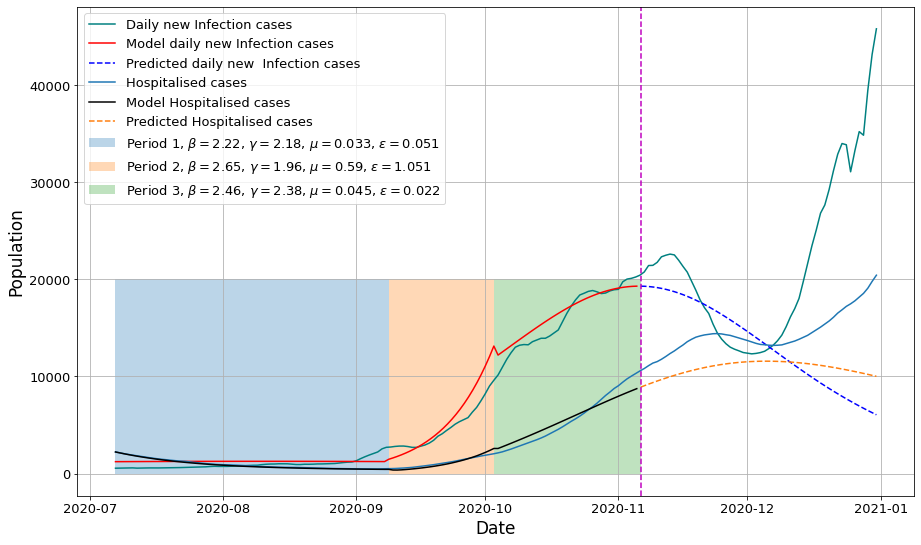

In [73]:
I_total = np.array([])
H_total = np.array([])


for i in range(len(t_span_stamps)):
    if i == 0:
        x_0 = np.array([54000000 - new_cases_I[0] - hospital_data[0] ,new_cases_I[0],hospital_data[0], 0])
        N = np.sum(x_0)
        theta = [b_0_stores[i], g_0_stores[i], i_h_stores[i], hr_stores[i],  N]
        t_span = t_span_stamps[(i)]  # Time limits
        t = t_stamps[(i)] # Time series, but want to only sample for period 1: 115
        sol = solve_ivp(sirh_odes, t_span , x_0, args = theta , t_eval = t)
        S = sol.y[0]
        I = sol.y[1]
        H = sol.y[2]
        R = sol.y[3]
        
        I_n = (np.multiply(S,I)*theta[0]) / theta[4]
        I_total = np.concatenate((I_total, I_n))
        H_total = np.concatenate((H_total, H))
        
        
    elif 0 < i < (len(t_span_stamps) - 1) :
        theta = [b_0_stores[i], g_0_stores[i], i_h_stores[i], hr_stores[i],  N]
        t_span = t_span_stamps[(i)]  # Time limits
        t = t_stamps[(i)]
        x_0 = np.array([S[-1], I[-1], H[-1], R[-1]])

        sol = solve_ivp(sirh_odes, t_span , x_0, args = theta , t_eval = t)
        S = sol.y[0]
        I = sol.y[1]
        H = sol.y[2]
        R = sol.y[3]
        I_n = (np.multiply(S,I)*theta[0]) / theta[4]
        I_total = np.concatenate((I_total, I_n))
        H_total = np.concatenate((H_total, H))
    
    else :
        t_span_stamps = [(np.array([1, 65])),(np.array([65, 90])), (np.array([90, 125]))]
        t_stamps = [(np.linspace(1, 65, 65 )),(np.linspace(65, 90, 26 )), (np.linspace(90, 125, 36 ))]

        
        t_span = np.array([t_span_stamps[(i)][0], 180])  # Time limits
        t =  np.linspace(t_span_stamps[(i)][0], 180, 91)
        x_0 = np.array([S[-1], I[-1],H[-1], R[-1]])

        theta = [b_0_stores[i], g_0_stores[i], i_h_stores[i], hr_stores[i],  N]
        sol = solve_ivp(sirh_odes, t_span , x_0, args = theta , t_eval = t)
        S = sol.y[0]
        I = sol.y[1]
        H = sol.y[2]
        R = sol.y[3]
        I_n = (np.multiply(S,I)*theta[0]) / theta[4]
        I_total = np.concatenate((I_total, I_n))
        H_total = np.concatenate((H_total, H))


dates1 = pd.date_range(start='07/07/2020', end='31/12/2020', periods = 182)
dates2 = pd.date_range(start='07/07/2020', end='31/12/2020', periods = 178)
t_span = np.array([1, lc])  # Time limits
t_tot = np.linspace(t_span[0], t_span[1], t_span[1] )

# plt.plot(new_cases.index, data)

new_cases_I = rolling_avg_df(df['newCasesBySpecimenDate'])
new_cases_I = new_cases_I.dropna()
hospital_data = rolling_avg_df(df['hospitalCases'])
hospital_data = hospital_data.dropna()


# # new_cases_or = rolling_avg_df(df['newCasesBySpecimenDate'])
# plt.plot(new_cases_I.index, new_cases_I, label = "Daily Infection Cases Data")
# plt.plot(hospital_data.index, hospital_data, label = "Hospital Cases")
# plt.plot(dates1[0:125],H_total[0:125], label = "Hospital model")
# plt.plot(dates1[125:], H_total[125:], label = "Predictive hosptial Model")

# plt.plot(dates1[0:125], I_total[0:125], label = "SIR Model, with 3 time splits")
# plt.plot(dates1[125:], I_total[125:], label = "Predictive Model")
# plt.axvline(dates1[125:126], c = 'm',ls = '--')

# plt.legend()

# plt.grid()
# plt.show()


# dates1 = pd.date_range(start='07/07/2020', end='31/12/2020', periods = 178)
plt.figure(figsize=(15,9))
plt.plot(new_cases_I.index, new_cases_I,label = 'Daily new Infection cases',color='teal')
plt.plot(dates1[0:125],I_total[0:125],label = 'Model daily new Infection cases', color = 'r')
plt.plot(dates1[125:],I_total[125:],label = 'Predicted daily new  Infection cases', ls = '--', color = 'b')
plt.plot(hospital_data.index, hospital_data, label = "Hospitalised cases")
plt.plot(dates1[0:125],H_total[0:125], label = "Model Hospitalised cases", color = 'black')
plt.plot(dates1[125:], H_total[125:], label = "Predicted Hospitalised cases", ls = '--')



plt.xlabel("Date", fontsize = 17)
plt.ylabel("Population", fontsize = 17)
plt.axvline(dates1[125:126], c = 'm',ls = '--')




# plt.plot(dates2,data,label = 'Daily new Infection cases',color='teal')
# plt.plot(dates2[0:126],I[0:126],label = r'Model daily new  Infection cases', color = 'black')
# plt.plot(dates2[125:],I[125:],label = r'Predicted daily new  Infection cases', color = 'b', ls = '--')
# plt.xlabel("Date", fontsize = 17)
# plt.ylabel("Population", fontsize = 17)

plt.fill_betweenx([0,20000], dates1[0], dates1[65], alpha = 0.3, label = r'Period 1, $\beta = 2.22$, $\gamma = 2.18$, $\mu = 0.033$, $\epsilon = 0.051$')
plt.fill_betweenx([0,20000], dates1[65], dates1[90], alpha = 0.3, label = r'Period 2, $\beta = 2.65$, $\gamma = 1.96$, $\mu = 0.59$, $\epsilon = 1.051$')
plt.fill_betweenx([0,20000], dates1[90], dates1[125], alpha = 0.3, label = r'Period 3, $\beta = 2.46$, $\gamma = 2.38$, $\mu = 0.045$, $\epsilon = 0.022$')

plt.legend(fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.grid()


plt.savefig('SIRH_5_PRED')
plt.show()





In [19]:
dates1 = pd.date_range(start='07/07/2020', end='31/12/2020', periods = 182)
print(dates1[125])
print(dates1[0])
print(dates1[-1])

2020-11-06 05:42:05.966850828
2020-07-07 00:00:00
2020-12-31 00:00:00
